In [159]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import functional as F
import cv2
import numpy as np

torch.manual_seed(17)

# Fastai Unet

In [160]:
from fastai.vision.all import *

### Dataloader

- define how to get images, how to get masks from image names, hos to read the mask 
- Mask is divided by 255 : 0 for bkg, 1 for sky
- create code list accordingly

In [161]:
import posixpath


def get_images(path):
    all_files = get_image_files(path)
    images = [i for i in all_files if str(i).endswith("jpg")]
    return images

def get_label(im_path):
    return ( posixpath.normpath(im_path) + '_skyMask.png')

In [162]:
TrainingFolderPath = Path('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/')
all_images = get_images(TrainingFolderPath)
all_images
get_label(all_images[0])

'/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/000000133567.jpg_skyMask.png'

In [163]:
codes = ['bkg' , 'sky']
#codes[255] = 'y'

def get_msk(fn):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = get_label(fn)
    msk = np.array(PILMask.create(fn))/255
    return PILMask.create(msk)


def get_y(o): return get_msk(o)


### Create dataloader

- use augmentation and normalize to imagenet target, as we will use pretrained network latter on

- see https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb for a proper exemple


In [164]:
def get_dls(bs, size):
    segmentation_datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                       get_items=get_images,
                                       get_y=get_y,
                                       splitter=RandomSplitter(seed=42),
                                       item_tfms=[Resize(460)],
                                       batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                                                   Normalize.from_stats(*imagenet_stats)])

    return segmentation_datablock.dataloaders(TrainingFolderPath, bs=bs)


def get_dls_no_transform(bs, size):
    segmentation_datablock2 = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                       get_items=get_images,
                                       get_y=get_y,
                                       splitter=RandomSplitter(seed=42),
                                       item_tfms=[],
                                       batch_tfms=[Normalize.from_stats(*imagenet_stats)])

    return segmentation_datablock2.dataloaders(TrainingFolderPath, bs=bs)
    # batch_tfms = [RandomResizedCrop(input_size, min_scale=0.05, max_scale=0.15), Normalize.from_stats(*imagenet_stats)]


Check a training batch

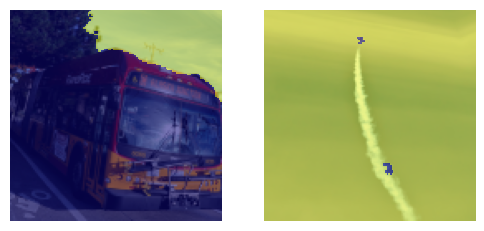

In [165]:
bs = 2
dls = get_dls(bs, 128)
dls.show_batch(cmap='plasma', vmin=0, vmax=1)


# Unet Model Load

- Note : fp16 (mixed precision) model training has been tried, but something wrong as loss is always NaN on my machine (is it a graphic card issue?)

- Pick a resnet18 as architecture as it is small and 'fast' to train



In [166]:
# SqueezeNet resnet18 resnet34 mobilenet_v3_small


In [167]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [168]:
#modelStep2_no_opt_resnet34_ADE20k.fastai
#modelStep1_resnet18_ADE20k.fastai
learn = unet_learner(dls, resnet34)
learn.load ("modelStep2_no_opt_resnet34_ADE20k.fastai", with_opt=False)

/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cstrauss/anaconda3/envs/progo/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


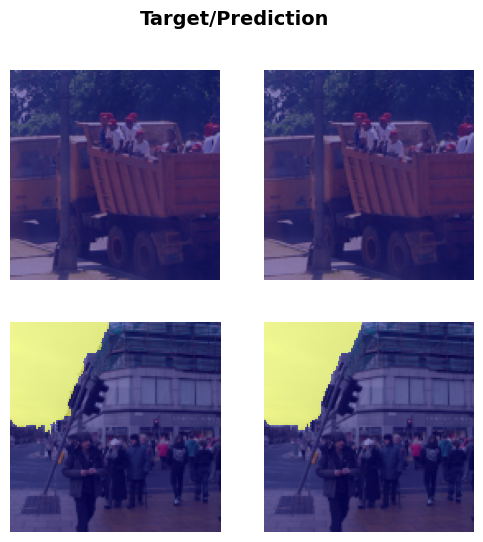

In [169]:
learn.show_results(cmap='plasma', vmin=0, vmax=1, shuffle=False)

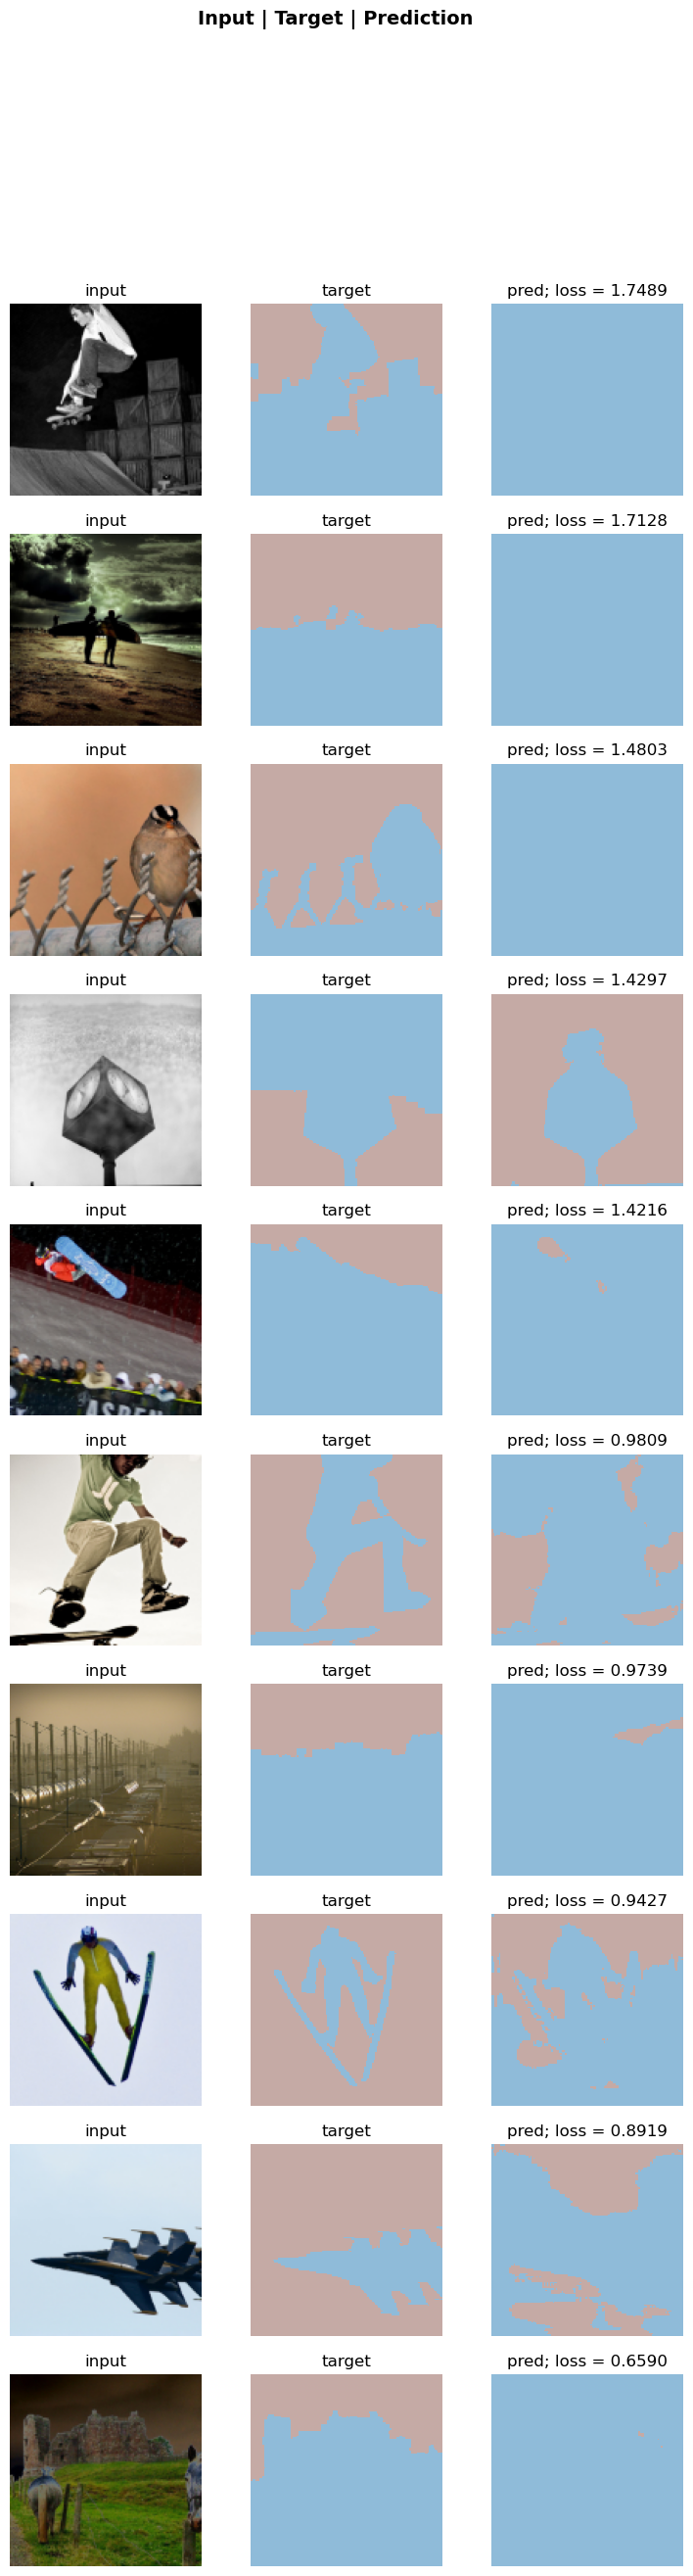

In [170]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=10)

In [171]:
from PIL import Image, ImageFilter

def saveImageAndMask(img: PILImage, pred, output_path = "result") :
    """Show the segmentation result on the image

    Args:
        img (PILImage): rgb image
        pred (Tensor): prediction out of .predict function
        justThePair (bool, optional): when true it gives a smaller display. Defaults to False.
    """
    mask = Image.fromarray(np.uint8(pred) * 255) 
    mask = mask.resize(img.size, resample=NEAREST)


    skyIdx =  np.array(mask, dtype=np.uint8) > 0
    masked_img = np.array(img, dtype=np.uint8)

    masked_img[skyIdx] =  masked_img[skyIdx] * 0.3#   [255, 0, 255]

    masked_img = Image.fromarray(masked_img).convert('RGB')
    masked_img.save(output_path + '.UnetComposite.jpg')

    mask.save(output_path + '.UnetMask.png')

    

In [172]:
def showImageAndMask(img: PILImage, pred, verbose_display = False) :
    """Show the segmentation result on the image

    Args:
        img (PILImage): rgb image
        pred (Tensor): prediction out of .predict function
        justThePair (bool, optional): when true it gives a smaller display. Defaults to False.
    """
    mask = Image.fromarray(np.uint8(pred) * 255) 
    mask = mask.resize(img.size, resample=NEAREST)


    skyIdx =  np.array(mask, dtype=np.uint8) > 0
    masked_img = np.array(img, dtype=np.uint8)

    masked_img[skyIdx] =  masked_img[skyIdx] * 0.3#   [255, 0, 255]

    if  not verbose_display :
        plt.figure()
        f, axarr = plt.subplots(1,2, figsize=(10, 10)) 
        axarr[0].imshow(img, cmap="gray")
        axarr[1].imshow(masked_img, cmap="gray")
    else :
        plt.figure()
        f, axarr = plt.subplots(1,3, figsize=(15, 15)) 
        axarr[0].imshow(img, cmap="gray")
        axarr[1].imshow(mask, cmap="gray")
        axarr[2].imshow(masked_img, cmap="gray")

        plt.figure(figsize=(15, 15))
        plt.imshow(masked_img, cmap="gray")

In [173]:
from PIL import Image, ImageFilter

normalizer = Normalize.from_stats(*imagenet_stats)

learn.dls = get_dls_no_transform(1, 224)  # size doesn't matter here

max_pixel_count = 1024 * 720  # GPU memory bound
# max_pixel_count = 324 * 240 # GPU memory bound


def predictDisplay(image_path: str, verbose_display=True, processing_size=None, save_image=False):
    """Open the image, run prediction and Display result for a image Path

    Args:
        image_path (str): path of the image
        simple (bool, optional):  when true it gives a smaller display. Defaults to False.
    """

    imgFull = PILImage.create(image_path)

    img = imgFull.copy()

    if processing_size != None:
        img = imgFull.resize((processing_size, processing_size))
        print("processed at fixed resolution ", img.size, image_path)
    else:
        aspect_ratio = img.size[0] / img.size[1]
        pixel_count = img.size[0] * img.size[1]

        if pixel_count > max_pixel_count:
            scaling_factor = math.sqrt(
                max_pixel_count / (aspect_ratio * img.size[1] * img.size[1]))
            # print(scaling_factor)
            img = img.resize(
                (int(img.size[0] * scaling_factor), int(img.size[1] * scaling_factor)))
            print("processed at low resolution ", img.size, image_path)
        else:
            print("processed at original resolution ", img.size, image_path)

    img = img.filter(ImageFilter.MedianFilter(3))

   # s imgSmall = img.resize((800,600)) # GPU memory bound

    # preprocess and normalized opened image
    #img_tensor = normalizer.encodes(img)

    # Get the prediction

    with learn.no_bar(), learn.no_logging():
        pred, label, prob = learn.predict(PILImage(img))

    # print(pred.shape)

    showImageAndMask(imgFull, pred, verbose_display)

    if save_image :
        image_name = os.path.basename(image_path)
        saveImageAndMask(imgFull,pred, "TestImagesUnetResults/" + image_name)


In [ ]:
img_path = '../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg'
predictDisplay(img_path, True, 56)
predictDisplay(img_path, True, 112)
predictDisplay(img_path, True, 224)
predictDisplay(img_path, True, 448)
predictDisplay(img_path, True, 896)

processed at original resolution  (625, 416) ../TestImages/On-the-Road.png
processed at original resolution  (1000, 664) ../TestImages/photo1.jpeg
processed at low resolution  (1246, 591) ../TestImages/2._MAD_12003_Chaoyang_Park_Plaza_i_02_overview_with_city_context.jpg
processed at original resolution  (1000, 662) ../TestImages/photo-1625726411847-8cbb60cc71e6.jpeg
processed at low resolution  (1051, 701) ../TestImages/route-deserte-montagnes-arriere-plan-dans-paysage-aride-iles-canaries-fuerteventura_462054-226.jpg
processed at original resolution  (635, 487) ../TestImages/635x487_100_300_000000x10x0.png
processed at original resolution  (512, 272) ../TestImages/exemple1.png
processed at original resolution  (731, 500) ../TestImages/ml_elcamino_ontheroad_02_0.jpg
processed at low resolution  (1052, 700) ../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg
processed at low resolution  (1051, 701) ../TestImages/ryan-schroeder-Gg7uKdHFb_c-unsplash.jpg
processed at original resolution 

/tmp/ipykernel_1616918/4250575851.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


processed at low resolution  (1051, 701) ../TestImages/12.jpg
processed at original resolution  (800, 533) ../TestImages/shanghai-morning-city-landscape-empty-asphalt-road-shanghai-morning-city-landscape-asphalt-road-155904083.jpg


<Figure size 640x480 with 0 Axes>

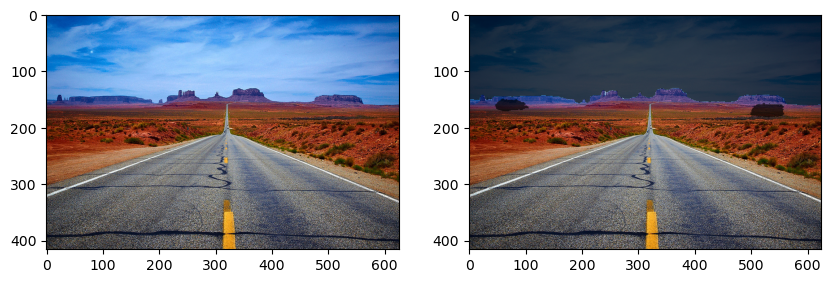

<Figure size 640x480 with 0 Axes>

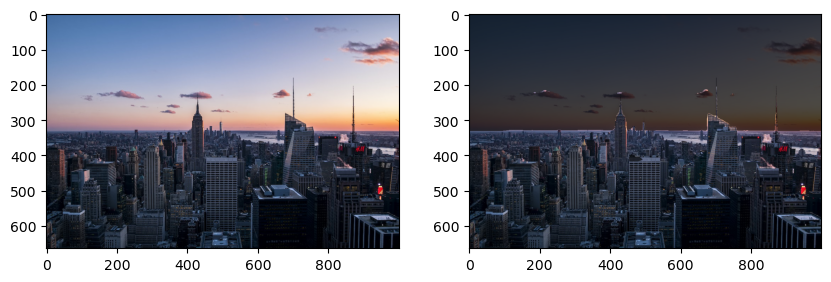

<Figure size 640x480 with 0 Axes>

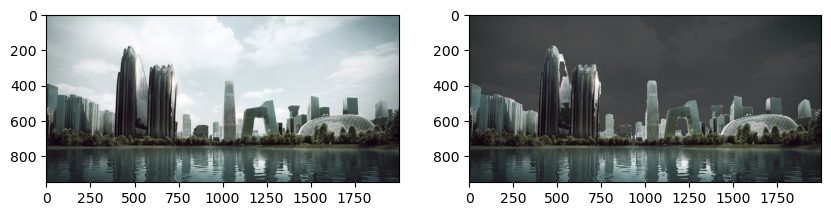

<Figure size 640x480 with 0 Axes>

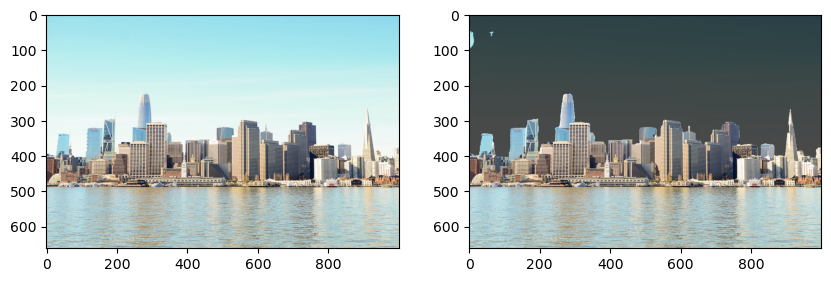

<Figure size 640x480 with 0 Axes>

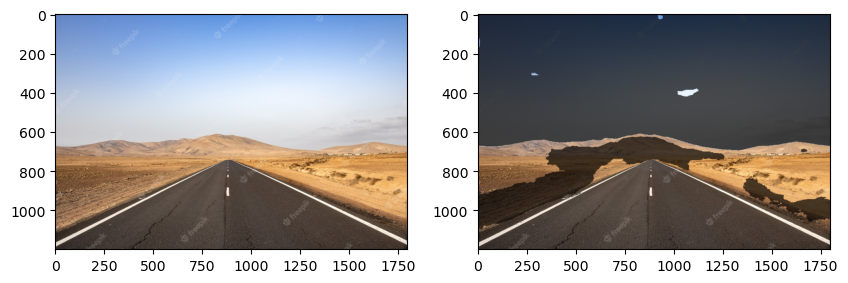

<Figure size 640x480 with 0 Axes>

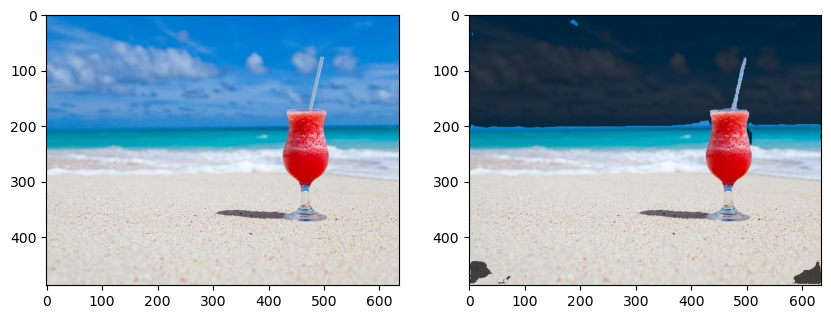

<Figure size 640x480 with 0 Axes>

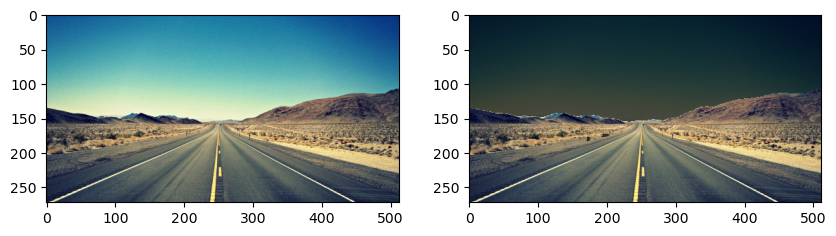

<Figure size 640x480 with 0 Axes>

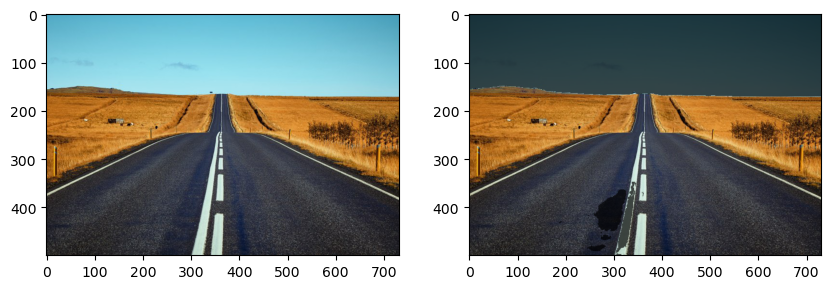

<Figure size 640x480 with 0 Axes>

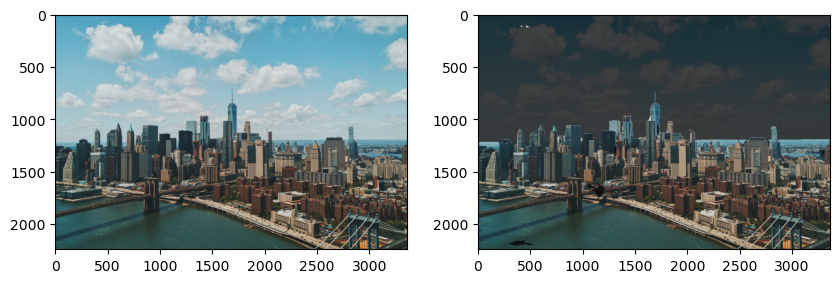

<Figure size 640x480 with 0 Axes>

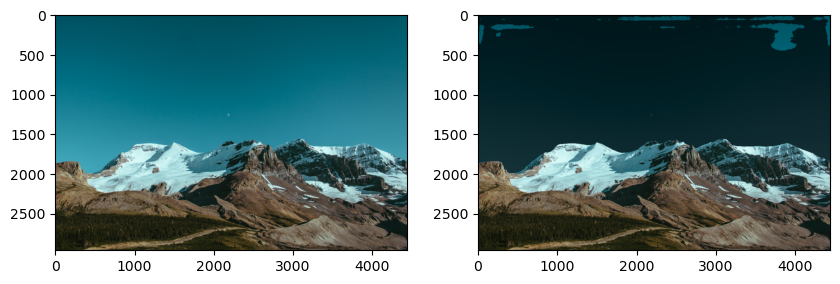

<Figure size 640x480 with 0 Axes>

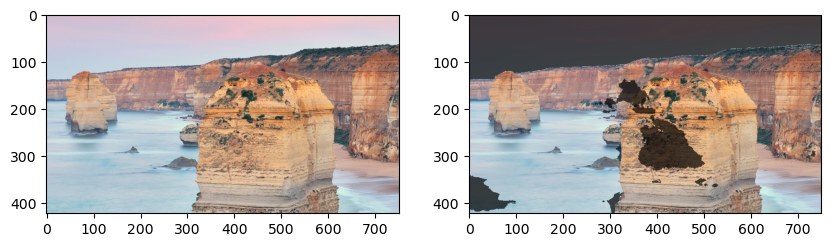

<Figure size 640x480 with 0 Axes>

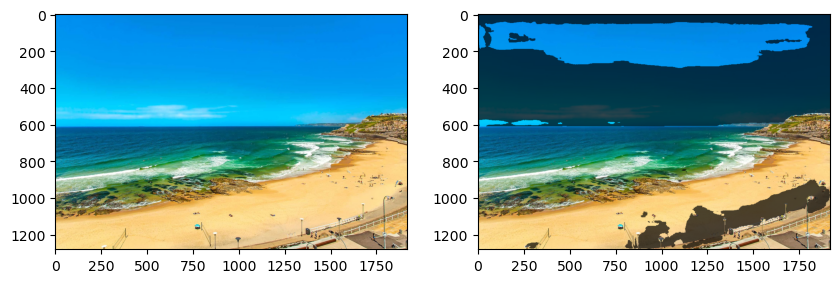

<Figure size 640x480 with 0 Axes>

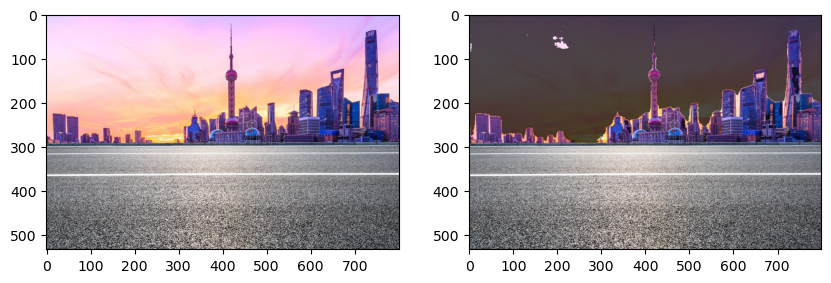

In [175]:
# Load the image
#predictAndDisplay('../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg')

for path in glob.glob('../TestImages/*') :
    predictDisplay(path, False, None, True)


# Proces large image with a Slidding Window

In [ ]:

# Imports PIL module 
from PIL import Image
  
# Load the large image
img =  Image.open(r'../TestImages/patrick-tomasso-SVVTZtTGyaU-unsplash.jpg')
width, height = img.size

# if(width > 1920):
#     img = img.resize((width//2,height//2))


# Define the patch size and stride
patch_size = 448
stride = patch_size

# Calculate the number of patches in each dimension
w, h = img.size 
n_patches_w = int(np.ceil((w - patch_size) / stride)) + 1
n_patches_h = int(np.ceil((h - patch_size) / stride)) + 1

w = w + patch_size
h = h + patch_size

print(img.size , n_patches_w, n_patches_h)
# Create an empty array to store the predicted patches
pred_patches = np.zeros((n_patches_w, n_patches_h, patch_size, patch_size))

print( pred_patches.shape)


# Iterate over the patches and make predictions
for j in range(n_patches_h):
    for i in range(n_patches_w):
        # Calculate the coordinates of the patch
        x1 = i * stride
        x2 = x1 + patch_size
        y1 = j * stride
        y2 = y1 + patch_size
        
        # Extract the patch from the image
        patch = img.crop((x1, y1, x2, y2))
   
        #img_tensor = normalizer.encodes(np.array(img_tensor))       
    
        # Make a prediction using the U-Net model
        with learn.no_bar(), learn.no_logging():
            pred = learn.predict(PILImage(patch))[0]
        
        showImageAndMask(patch, pred, true)

        # Store the predicted patch in the array
        pred_patches[i, j] = pred.data.numpy()

# Stitch the predicted patches back together to create the final prediction
pred = np.zeros((h, w))
print( pred.shape)
for j in range(n_patches_h):
    for i in range(n_patches_w):
        # Calculate the coordinates of the patch
        x1 = i * stride
        x2 = x1 + patch_size
        y1 = j * stride
        y2 = y1 + patch_size
        
        # Add the patch to the final prediction
        pred[y1:y2, x1:x2] += pred_patches[i, j]

# Normalize the final prediction
pred /= np.max(pred)

# Convert the prediction to a PIL Image and save it
pred = (pred * 255).astype(np.uint8)
pred_img = Image.fromarray(pred)
w, h = img.size 
pred_img = pred_img.crop((0, 0, w, h))
pred_img.save('test.png')

plt.figure(figsize=(15, 15))
plt.imshow(pred_img, cmap="gray")

showImageAndMask(img, pred_img)


In [177]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from tqdm import tqdm


def confusion_matrix(
    learn: Learner,
    dl: DataBlock.dataloaders
) -> [np.ndarray, np.ndarray]:
    """ Compute confusion matrix.

    Args:
        learn: trained model
        dl: dataloader with images and ground truth masks

    Return:
        The un-normalized and the normalized confusion matrices.
    """
    y_gts = []
    y_preds = []

    # Loop over all images
    with tqdm(total=len(dl.items)) as pbar:
        for im_path in dl.items:
            pbar.update(1)
            img = PILImage.create(im_path)
            gt_mask = dl.tfms[1](im_path)
            with learn.no_bar(), learn.no_logging():
                pred_mask, _, _ = learn.predict(img)

            pred_mask = Image.fromarray(np.uint8(pred_mask))
            pred_mask = pred_mask.resize(gt_mask.size, resample=NEAREST)

            gt_mask = np.array(gt_mask, dtype=np.uint8)
            pred_mask = np.array(pred_mask, dtype=np.uint8)

            # Store predicted and ground truth labels
            assert len(gt_mask.flatten()) == len(pred_mask.flatten())

            y_gts.extend(gt_mask.flatten())
            y_preds.extend(pred_mask.flatten())

    # Compute confusion matrices

    cmat = sk_confusion_matrix(y_gts, y_preds)
    cmat_norm = sk_confusion_matrix(y_gts, y_preds, normalize="true")

    return cmat, cmat_norm


In [178]:
cmat, cmat_norm = confusion_matrix(learn, dls.valid_ds)


#accs = print_accuracies(cmat, cmat_norm, classes)

100%|██████████| 335/335 [01:03<00:00,  5.25it/s]


In [179]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import cm

def plot_confusion_matrix(
    cmat: np.ndarray,
    cmat_norm: np.ndarray,
    classes: List[str],
    show: bool = True,
    figsize: Tuple[int, int] = (16, 4),
) -> None:
    """ Plot the confusion matrices.

    Args:
        cmat: confusion matrix (with raw pixel counts)
        cmat_norm: normalized confusion matrix
        classes: list of class names
        show: set to true to call matplotlib's show()
        figsize: figure size
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ConfusionMatrixDisplay(confusion_matrix = cmat, display_labels = classes).plot(
        ax=ax1,
        cmap=cm.get_cmap("Blues"),
        xticks_rotation="vertical",
        values_format="d",
    )
    ConfusionMatrixDisplay(confusion_matrix = cmat_norm, display_labels = classes).plot(
        ax=ax2, cmap=cm.get_cmap("Blues"), xticks_rotation="vertical"
    )
    ax1.set_title("Confusion matrix")
    ax2.set_title("Normalized confusion matrix")

    if show:
        plt.show()

# Confusion matrix For ADE20k training, testing on COCO

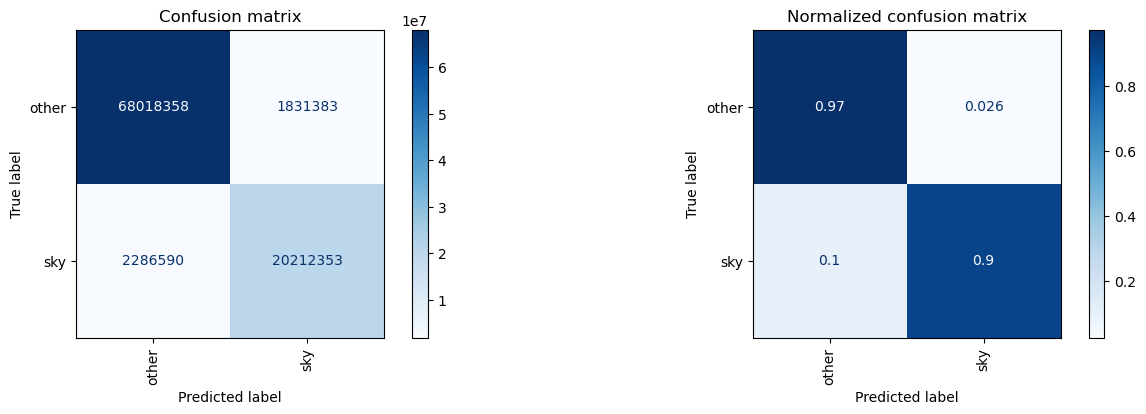

In [180]:
#accs = print_accuracies(cmat, cmat_norm, classes)
plot_confusion_matrix(cmat, cmat_norm, (['other', 'sky']))